In [1]:
# Yernar Shambayev, DL-2
# Сделайте генератор лиц аниме на основе датасета 
# https://www.kaggle.com/soumikrakshit/anime-faces (можно взять часть данных)

import torch.nn as nn
import torch.optim as optim
import torch.utils.data
from torch.utils.data.dataloader import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
random.seed(777)
torch.manual_seed(777)

# Гиперпараметры
num_workers = 4
batch_size = 128
image_size = 64
nc = 3
nz = 100
ngf = 64
ndf = 64

real_label = 1
fake_label = 0

lr = 0.0002
beta1 = 0.5
num_epochs = 500
img_list = []
iters = 0
step = 1000

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
dataset = datasets.ImageFolder(root='./data/',
                               transform=transforms.Compose([
                                   transforms.Resize(image_size),
                                   transforms.CenterCrop(image_size),
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                               ]))

# Ограничим набор аниме-картинок для нейросети (1000 картинок)

class LimitDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, n):
        self.dataset = dataset
        self.n = n

    def __len__(self):
        return self.n

    def __getitem__(self, i):
        return self.dataset[i]

dataloader = DataLoader(LimitDataset(dataset, n=1000), batch_size=batch_size,
                        shuffle=True, num_workers=num_workers)

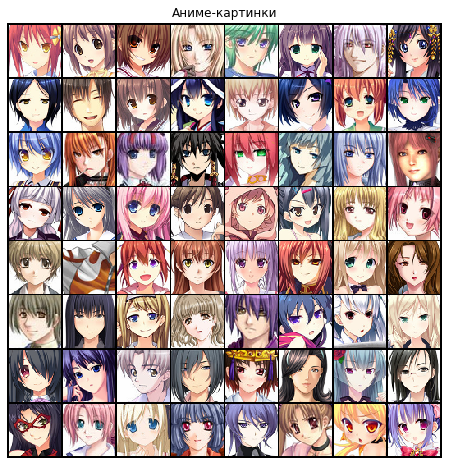

In [4]:
images, _ = next(iter(dataloader))
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Аниме-картинки")
grid = make_grid(images.to(device)[:64], padding=2, normalize=True).cpu()
img = np.transpose(grid, (1, 2, 0))
plt.imshow(img)

In [5]:
# Генератор и дискриминатор

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)
    
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

In [6]:
Gen = Generator().to(device)
Gen.apply(weights_init)

Generator(
  (model): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

In [7]:
Discr = Discriminator().to(device)
Discr.apply(weights_init)

Discriminator(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

In [8]:
loss = nn.BCELoss()
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

optimizerD = optim.Adam(Discr.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(Gen.parameters(), lr=lr, betas=(beta1, 0.999))

In [9]:
# Обучение генератора и дискриминатора

for epoch in range(num_epochs):
    for i, data in (enumerate(dataloader)):
        Discr.zero_grad()

        images = data[0].to(device)
        b_size = images.size(0)
        labels = torch.full((b_size,), real_label, device=device)
        real_out = Discr(images).view(-1)

        loss_real = loss(real_out, labels)
        loss_real.backward()
        dx = real_out.mean().item()

        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake_image = Gen(noise)
        labels.fill_(fake_label)
        fake_out = Discr(fake_image.detach()).view(-1)

        loss_fake = loss(fake_out, labels)
        loss_fake.backward()

        dz1 = fake_out.mean().item()
        loss_D = loss_fake + loss_real
        optimizerD.step()

        #########

        Gen.zero_grad()

        labels.fill_(real_label)
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake_image = Gen(noise)
        output = Discr(fake_image).view(-1)

        loss_G = loss(output, labels)
        loss_G.backward()
        dz2 = output.mean().item()
        optimizerG.step()

        if (iters % 500 == 0) or ((epoch == num_epochs - 1) and (i == len(dataloader) - 1)):
            with torch.no_grad():
                fake = Gen(fixed_noise).detach().cpu()
            img_list.append(make_grid(fake, padding=2, normalize=True))            
        iters += 1
        
    if epoch % 10 == 0:
        print(f'Эпоха: {epoch+1}, потери дискриминатора: {loss_D.item():.4f}, потери генератора: {loss_G.item():.4f}')

Эпоха: 1, потери дискриминатора: 0.1905, потери генератора: 6.7831
Эпоха: 11, потери дискриминатора: 0.5685, потери генератора: 5.3199
Эпоха: 21, потери дискриминатора: 0.6259, потери генератора: 10.1682
Эпоха: 31, потери дискриминатора: 0.4605, потери генератора: 5.6568
Эпоха: 41, потери дискриминатора: 0.4782, потери генератора: 7.3685
Эпоха: 51, потери дискриминатора: 0.3783, потери генератора: 6.9754
Эпоха: 61, потери дискриминатора: 0.5834, потери генератора: 5.8472
Эпоха: 71, потери дискриминатора: 0.3844, потери генератора: 6.0289
Эпоха: 81, потери дискриминатора: 0.4338, потери генератора: 6.1886
Эпоха: 91, потери дискриминатора: 1.0784, потери генератора: 9.4679
Эпоха: 101, потери дискриминатора: 0.6556, потери генератора: 9.2514
Эпоха: 111, потери дискриминатора: 0.3605, потери генератора: 5.5342
Эпоха: 121, потери дискриминатора: 0.3477, потери генератора: 5.0249
Эпоха: 131, потери дискриминатора: 1.9364, потери генератора: 4.8195
Эпоха: 141, потери дискриминатора: 0.5008, п

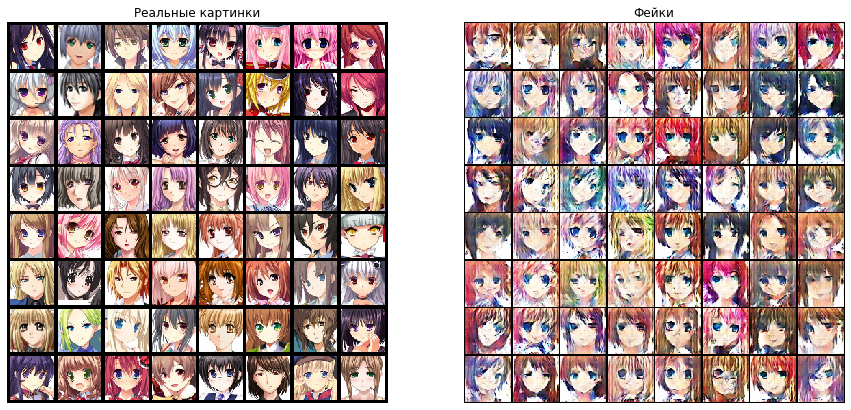

In [10]:
real_batch = next(iter(dataloader))

# Реальные картинки
plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 1)
plt.axis("off")
plt.title("Реальные картинки")
plt.imshow(np.transpose(make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(), (1, 2, 0)))

# Фейки
plt.subplot(1, 2, 2)
plt.axis("off")
plt.title("Фейки")
plt.imshow(np.transpose(img_list[-1], (1, 2, 0)))
plt.show()